## Importing libraries

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM, Flatten

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [185]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", usecols = ["day", "TS_change", "VS_change", "reactor1"])
df.sort_index(inplace=True)
df.head()

,TS_change,VS_change,reactor1
day,,,
0,0.0000,0.000,0
1,12.3436,12.035,100
2,12.3436,12.035,120
3,12.3436,12.035,100
4,12.3436,12.035,100


## Plotting the different values
This section takes a look at the trend in the biogas values, VS and TS values.

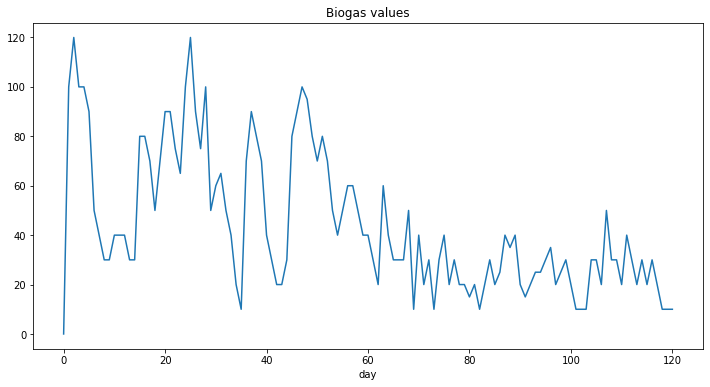

In [186]:
# Biogas values
df["reactor1"].plot(figsize=(12,6), title= "Biogas values")

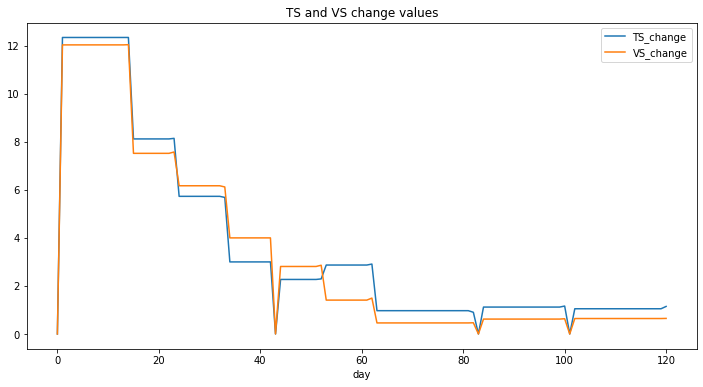

In [187]:
# VS and TS values
df[["TS_change", "VS_change"]].plot(figsize=(12,6), legend=True, title = "TS and VS change values")

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

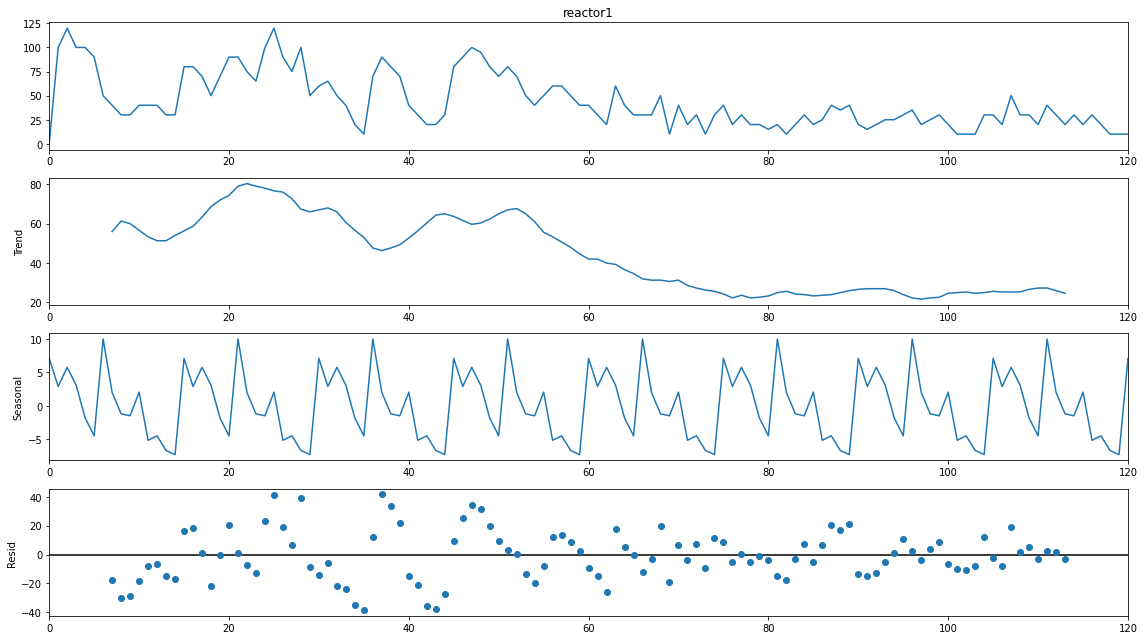

In [188]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x= df['reactor1'],  period = 15, model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [189]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [190]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), :]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, -1])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 8
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

112

## Splitting into train and test set
This needs to be done sequentially.

In [191]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Building LSTM models

## Input shape
LSTMs expect input array to be a 3D array: (batch_size, time_steps, seq_len)
* `batch_size` = Number of inputs in the training data
* `time_steps` = Number of historical datapoints being given
* `seq_len` = Number of features in a single historical datapoint

Example 1: If there are 2500 training sentences, with 50 words in each, with each word being encoded as an integer, then the input shape would be: `(2500, 50, 1)` 

So, for univariate analysis, the input shape will be:  
`(num_training_observations, sequence_size, 1)`

For multivariate analysis, the shape does not need to change.


## a) Single LSTM layer (64 neurons)

In [80]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 262ms/step - loss: 0.9128 - val_loss: 0.5053
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.8058 - val_loss: 0.4100
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.7349 - val_loss: 0.3322
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6972 - val_loss: 0.2756
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6745 - val_loss: 0.2379
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6539 - val_loss: 0.2121
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6422 - val_loss: 0.1913
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6292 - val_loss: 0.1766
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6164 - val_loss: 0.1677
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6029 - val_loss: 0.1621
Epoch 11/100
3/3 [

### Plotting the loss

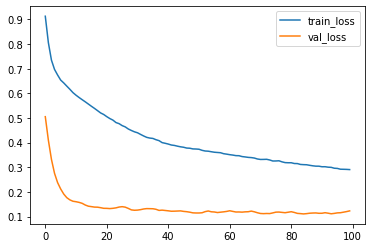

In [82]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 5ms/step


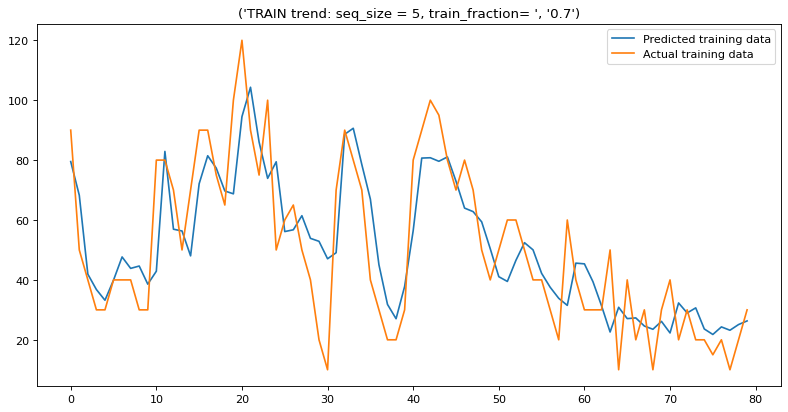

In [83]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 5ms/step


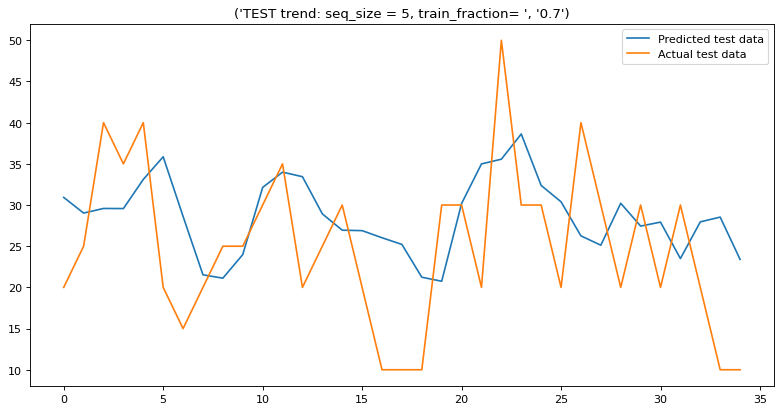

In [84]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

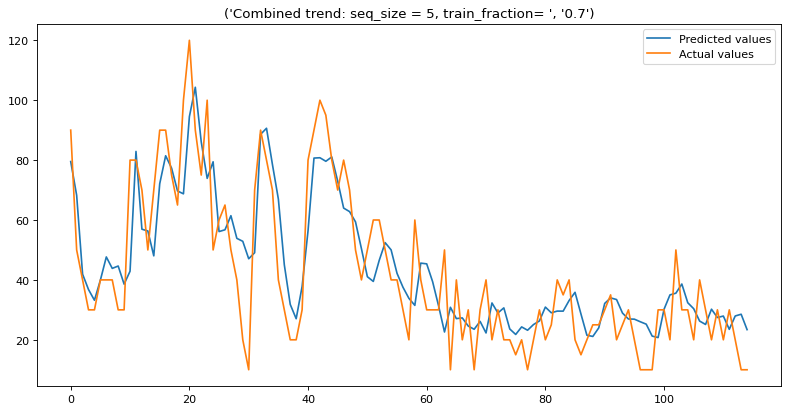

In [85]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [86]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.685 ,  -0.053 ,  0.719


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [87]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  15.014 ,  9.814 ,  13.643


### Analysis
**1. Sequence size of 5, train size of 0.7**  
1. Trend is followed very faintly, slight lag is present. Curve is not smooth.
2. r2 score:  0.685 ,  -0.053 ,  0.719
3. RMSE:  15.014 ,  9.814 ,  13.643

Increasing the sequence size further makes the test values behvave like a straight line, close to the mean.


## b) 1 LSTM + 1 Dense layer

In [96]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 20)                1920      
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,361
Trainable params: 2,361
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 256ms/step - loss: 1.0722 - val_loss: 0.4139
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 1.0117 - val_loss: 0.3993
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9600 - val_loss: 0.3799
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.9167 - val_loss: 0.3593
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8806 - val_loss: 0.3389
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8499 - val_loss: 0.3196
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8274 - val_loss: 0.2998
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8044 - val_loss: 0.2806
Epoch 9/100
3/3 [==============================] - 0s 16ms/step - loss: 0.7819 - val_loss: 0.2631
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.7651 - val_loss: 0.2506
Epoch 11/100
3/3 [

### Plotting the loss

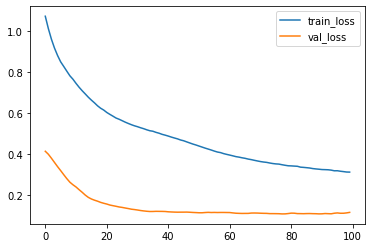

In [98]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 5ms/step


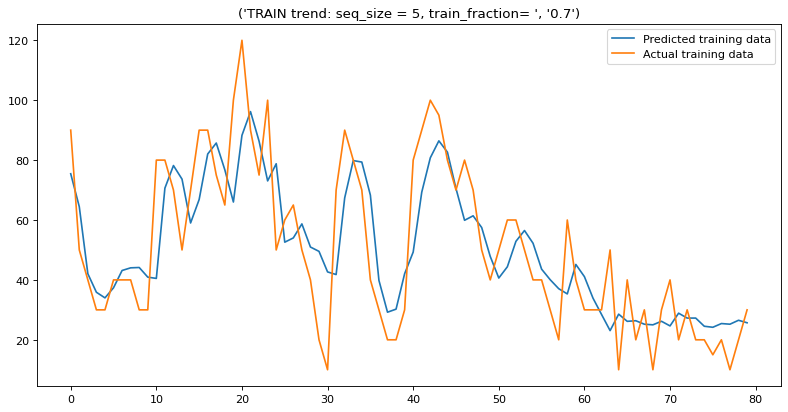

In [99]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 5ms/step


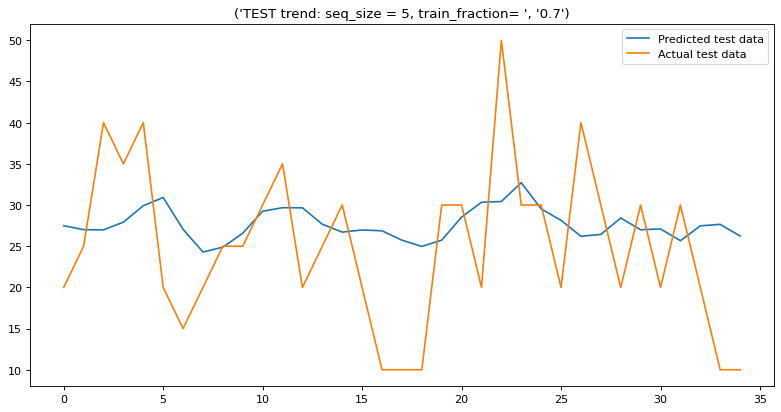

In [100]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

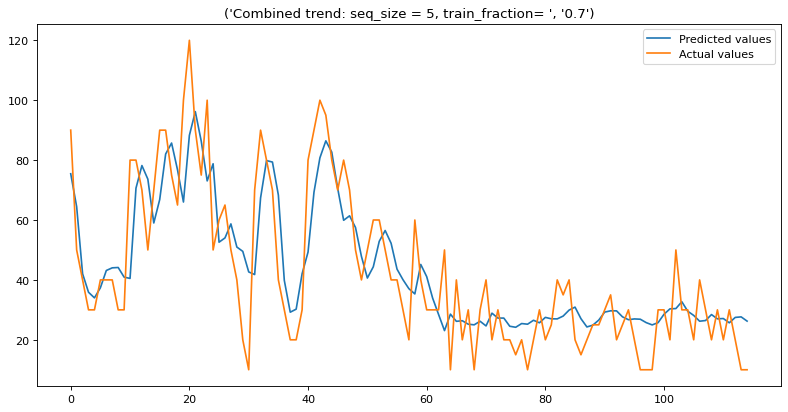

In [101]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [102]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.661 ,  0.007 ,  0.703


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [103]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  15.588 ,  9.53 ,  14.024


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. Train values: Slight lag is present. Graph has become smoother than previous variation.
2. Test values: Graph defautls to mean values. Very slight variations occur.
3. r2 score:  0.661 ,  0.007 ,  0.703
4. RMSE:  15.588 ,  9.53 ,  14.024



## c) 2 LSTM layers 


In [160]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 20)             1920      
                                                                 
 lstm_13 (LSTM)              (None, 20)                3280      
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,221
Trainable params: 5,221
Non-trainable params: 0
_________________________________________________________________


In [161]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 4s 325ms/step - loss: 1.0393 - val_loss: 0.5483
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 1.0042 - val_loss: 0.5342
Epoch 3/100
3/3 [==============================] - 0s 26ms/step - loss: 0.9730 - val_loss: 0.5173
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.9462 - val_loss: 0.4996
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9218 - val_loss: 0.4826
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8974 - val_loss: 0.4660
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 0.8784 - val_loss: 0.4484
Epoch 8/100
3/3 [==============================] - 0s 26ms/step - loss: 0.8576 - val_loss: 0.4300
Epoch 9/100
3/3 [==============================] - 0s 19ms/step - loss: 0.8358 - val_loss: 0.4122
Epoch 10/100
3/3 [==============================] - 0s 19ms/step - loss: 0.8198 - val_loss: 0.3959
Epoch 11/100
3/3 [

### Plotting the loss

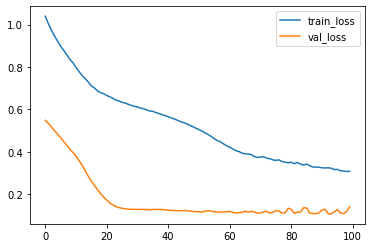

In [162]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 5ms/step


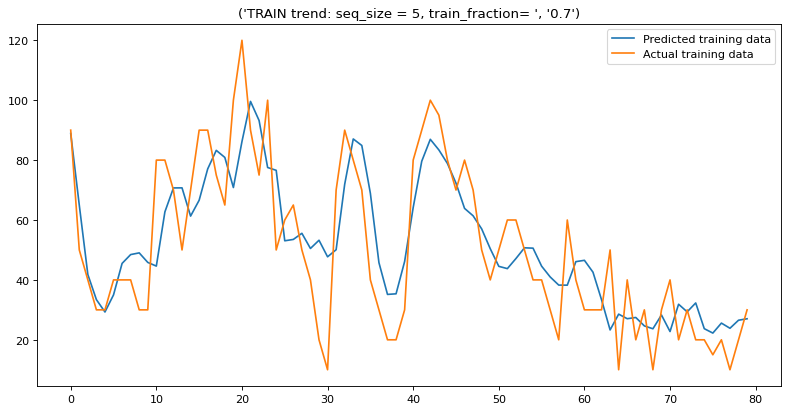

In [163]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 5ms/step


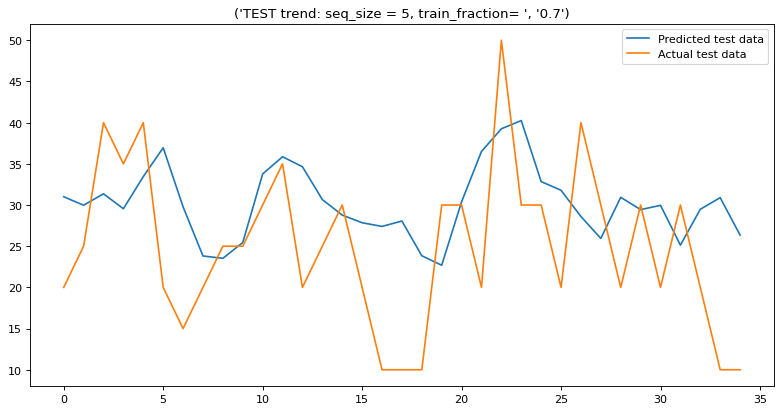

In [164]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

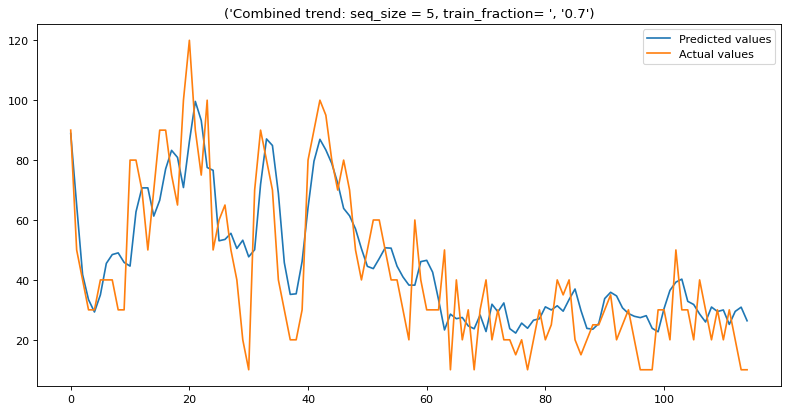

In [165]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [166]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.669 ,  -0.199 ,  0.701


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [167]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  15.391 ,  10.472 ,  14.077


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. Smoother than before. Slight lag is present. Values in the test set follow slight trend, but still near the mean.
3. r2 score:  0.669 ,  -0.199 ,  0.701
4. RMSE:  15.391 ,  10.472 ,  14.077





## d) 2 LSTM layers + 1 Dense layer


In [192]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 8, 20)             1920      
                                                                 
 lstm_17 (LSTM)              (None, 20)                3280      
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,641
Trainable params: 5,641
Non-trainable params: 0
_________________________________________________________________


In [193]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 4s 320ms/step - loss: 0.9493 - val_loss: 0.5833
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9269 - val_loss: 0.5654
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.9088 - val_loss: 0.5524
Epoch 4/100
3/3 [==============================] - 0s 33ms/step - loss: 0.8953 - val_loss: 0.5387
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.8792 - val_loss: 0.5251
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 0.8651 - val_loss: 0.5081
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 0.8512 - val_loss: 0.4909
Epoch 8/100
3/3 [==============================] - 0s 20ms/step - loss: 0.8338 - val_loss: 0.4709
Epoch 9/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8152 - val_loss: 0.4460
Epoch 10/100
3/3 [==============================] - 0s 22ms/step - loss: 0.7948 - val_loss: 0.4175
Epoch 11/100
3/3 [

### Plotting the loss

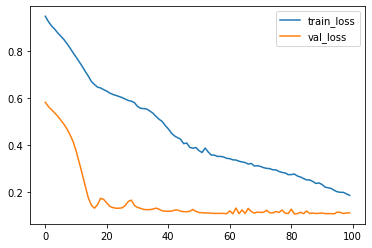

In [194]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 5ms/step


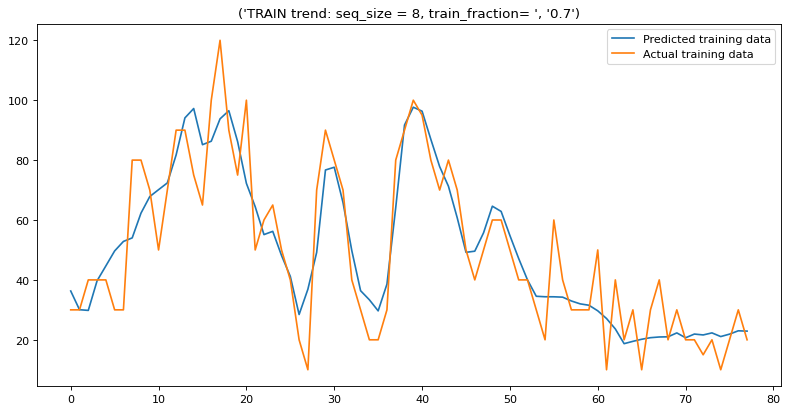

In [195]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 6ms/step


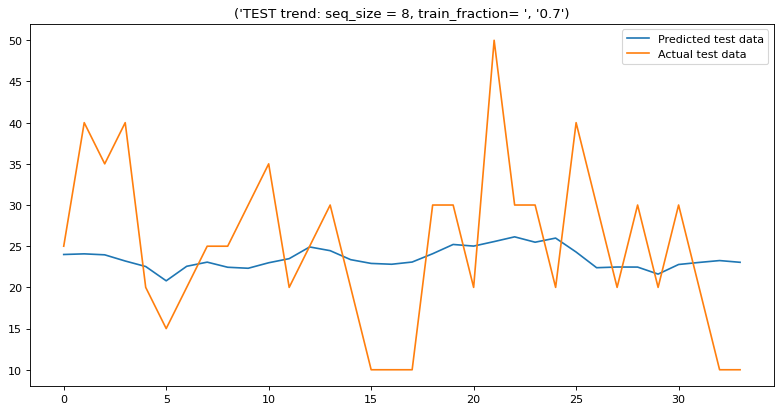

In [196]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

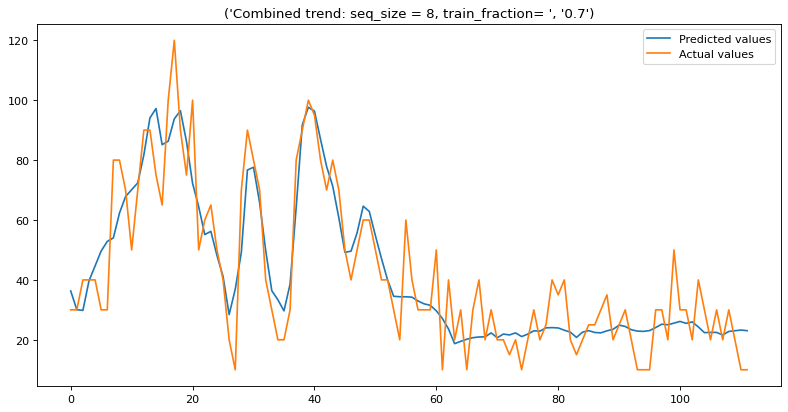

In [197]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [198]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.803 ,  0.054 ,  0.809


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [199]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  11.946 ,  9.399 ,  11.234


### Analysis
**1. Sequence size of 8, train size of 0.7**
1. Train set: Smooth curve.
2. Test set: Very much near the mean.
3. r2 score:  0.803 ,  0.054 ,  0.809
4. RMSE:  11.946 ,  9.399 ,  11.234


